# Brief sur la classification de CV


## 1. Importation des librairies et dataset

In [1]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [2]:
df = pd.read_csv('DataSet.csv', delimiter=',')
df.head(5)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


## 2. Information sur les données

In [3]:
df['Category'].value_counts()

Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Mechanical Engineer          40
Data Science                 40
ETL Developer                40
Operations Manager           40
Sales                        40
Blockchain                   40
Arts                         36
Database                     33
PMO                          30
Electrical Engineering       30
Health and fitness           30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
Civil Engineer               24
SAP Developer                24
Advocate                     20
Name: Category, dtype: int64

In [4]:
print(df.shape)

(962, 2)


## 3. Traitement des données

In [5]:
def clean(text, remove_stopwords=False):
    # suppression des balises html
    review_text = BeautifulSoup(text).get_text()
    # suppression des nombres
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
    # passage en minuscule et split des mots
    words = review_text.lower().split()
    # suppression des stopwords (false par default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return (words)

In [6]:
clean_resume = []
for resume in df["Resume"]:
    clean_resume.append( clean( resume, remove_stopwords=True ))

In [7]:
print(clean_resume[0][:20])

['skills', 'programming', 'languages', 'python', 'pandas', 'numpy', 'scipy', 'scikit', 'learn', 'matplotlib', 'sql', 'java', 'javascript', 'jquery', 'machine', 'learning', 'regression', 'svm', 'na', 'bayes']


In [8]:
df["clean"]=clean_resume

In [9]:
df.head(5)

,Category,Resume,clean
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, may, b, e, uit, rgpv..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, interest, deep, learning, control, sys..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, r, python, sap, hana, tableau, sap, h..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ..."


### Préprocessing

In [10]:
import nltk.data 

In [11]:
# téléchargement du tokenizer punkt
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [12]:
def funct(text, tokenizer, remove_stopwords=False):
    # utilisation du tokenizer NLTK pour split les paragraphes en phrases 
    tokens = tokenizer.tokenize(text.strip())
    
    resume = []
    for token in tokens:
        # si la phrase est vide, la skip
        if len(token) > 0:
            f1 = clean(token, remove_stopwords)    
            resume.append(f1)

    return resume

In [13]:
sentences = []

print ("Parsing sentences from training set")
for resume in df['Resume']:
    sentences += funct(resume, tokenizer)

Parsing sentences from training set


C:\Users\utilisateur\anaconda3\lib\site-packages\bs4\__init__.py:332: MarkupResemblesLocatorWarning: "." looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [14]:
df.head(5)

,Category,Resume,clean
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, may, b, e, uit, rgpv..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, interest, deep, learning, control, sys..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, r, python, sap, hana, tableau, sap, h..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ..."


In [15]:
from sklearn.model_selection import train_test_split

In [16]:
# split du jeu de données
X_train, X_test, y_train, y_test = train_test_split(df.clean, df.Category, test_size=200, random_state=42)

In [17]:
print(X_train.shape)
print(y_train.shape)

(762,)
(762,)


In [18]:
import gensim
from gensim import models
from gensim.models import Word2Vec
from gensim.test.utils import common_texts

In [19]:
# paramètres pour l'entrainement du modèle
num_features = 300                         
min_word_count = 20                           
num_workers = 4       
context = 2                                                                                              
downsampling = 0.00001 
alpha = 0.03
min_alpha=0.0007
negative=20

In [20]:
# initialisation et entrainement du modèle
print ("Training model...")
w2v_model = Word2Vec(min_count=min_word_count,
                     window=context,
                     size=num_features,
                     sample=downsampling, 
                     alpha=alpha, 
                     min_alpha=min_alpha, 
                     negative=negative,
                     workers=num_workers)
print("End of training  ")

w2v_model.build_vocab(X_train, progress_per=10000)

Training model...
End of training  


In [21]:
w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)


(824440, 7122750)

In [22]:
w2v_model.wv.vectors.shape

(1944, 300)

### Sauvegarde du w2v

In [23]:
model_name = "model_w2v"
w2v_model.save(model_name)

In [24]:
def makeFeatureVec(words, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,),dtype="float32")
    #
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    #
    # Loop over each word in the review and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [25]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter%100. == 0.:
            print ("Review %d of %d" % (counter, len(reviews)))            
       # 
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[counter] = makeFeatureVec(review, model, num_features)
       #
       # Increment the counter
       counter = counter + 1
    return reviewFeatureVecs

In [26]:
trainDataVecs = getAvgFeatureVecs(X_train, w2v_model, 300 )
testDataVecs = getAvgFeatureVecs(X_test, w2v_model, 300 )

Review 0 of 762


<ipython-input-24-b912749af2b2>:19: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  featureVec = np.add(featureVec,model[word])


Review 100 of 762
Review 200 of 762
Review 300 of 762
Review 400 of 762
Review 500 of 762
Review 600 of 762
Review 700 of 762
Review 0 of 200
Review 100 of 200


In [27]:
print(trainDataVecs.shape)
print(testDataVecs.shape)

(762, 300)
(200, 300)


## 4. Random Forest

In [28]:
# Fit a random forest to the training data, using 100 trees
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier( n_estimators = 100 )

print ("Fitting a random forest to labeled training data...")
forest = forest.fit( trainDataVecs, y_train )
# ici faut pas prendre trainDataVecs mais les sacs de centroids

# Test & extract results 
result = forest.predict( testDataVecs )

# Write the test results 
output = pd.DataFrame( data={"id":y_test, "sentiment":result} )

Fitting a random forest to labeled training data...


In [29]:
output

,id,sentiment
344,Java Developer,Java Developer
381,Java Developer,Java Developer
351,Java Developer,Java Developer
778,Hadoop,Hadoop
277,Health and fitness,Health and fitness
...,...,...
549,Operations Manager,Operations Manager
280,Health and fitness,Health and fitness
109,Arts,Arts
77,HR,HR


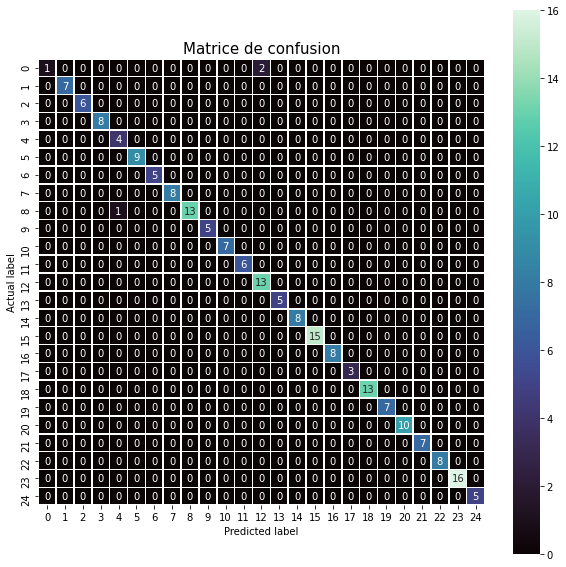

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt


c_m = confusion_matrix(y_test, result)
plt.figure(figsize=(10,10))
sns.heatmap(c_m, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()


In [31]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test,result)
print('Accuracy: {}'.format(round(score,3)))

Accuracy: 0.985


## 5. Sacs de centroïds

In [32]:
from sklearn.cluster import KMeans
import time


start = time.time() # Start time  23 minutes

# Set "k" (num_clusters) to be 1/5th of the vocabulary size, or an
# average of 5 words per cluster

num_clusters = w2v_model.wv.vectors.shape[0] / 5
num_clusters


# Initalize a k-means object and use it to extract centroids
kmeans_clustering = KMeans( n_clusters = int(num_clusters) )
idx = kmeans_clustering.fit_predict(w2v_model.wv.vectors)

# Get the end time and print how long the process took
end = time.time()
elapsed = end - start
print ("Time taken for K Means clustering: ", elapsed, "seconds.")

Time taken for K Means clustering:  35.0528085231781 seconds.


In [33]:
print(num_clusters)

388.8


In [34]:
word_centroid_map = dict(zip( w2v_model.wv.index2word, idx ))


In [35]:
# For the first 10 clusters
for cluster in range(0,10):
    #
    # Print the cluster number  
    print ("\nCluster %d" % cluster)
    #
    # Find all of the words for that cluster number, and print them out
    words = []
    values=list(word_centroid_map.values())
    keys=list(word_centroid_map.keys())
    for i in range(0,len(word_centroid_map.values())):
        if( values[i] == cluster ):
            words.append(keys[i])
    print (words)


Cluster 0
['build', 'continuous', 'logs', 'branches', 'repositories', 'merging']

Cluster 1
['windows', 'operating', 'xp', 'studio', 'eclipse']

Cluster 2
['front', 'categories', 'go', 'attendance', 'specially', 'search', 'estate', 'password']

Cluster 3
['java']

Cluster 4
['course', 'learner', 'association']

Cluster 5
['vendors']

Cluster 6
['nagpur', 'secondary']

Cluster 7
['hibernate', 'ee']

Cluster 8
['employee', 'commercial', 'events', 'uk', 'take', 'offers', 'duties', 'iso', 'task', 'satisfaction', 'plus', 'suggesting', 'techno', 'conditions', 'conference', 'carry', 'hours', 'establish', 'responses', 'kyc', 'gm', 'holds', 'receivables', 'rfq']

Cluster 9
['year']


In [36]:
def create_bag_of_centroids( wordlist, word_centroid_map ):
    #
    # The number of clusters is equal to the highest cluster index
    # in the word / centroid map
    num_centroids = max( word_centroid_map.values() ) + 1
    #
    # Pre-allocate the bag of centroids vector (for speed)
    bag_of_centroids = np.zeros( num_centroids, dtype="float32" )
    #
    # Loop over the words in the review. If the word is in the vocabulary,
    # find which cluster it belongs to, and increment that cluster count 
    # by one
    for word in wordlist:
        if word in word_centroid_map:
            index = word_centroid_map[word]
            bag_of_centroids[index] += 1
    #
    # Return the "bag of centroids"
    return bag_of_centroids

In [37]:
# Pre-allocate an array for the training set bags of centroids (for speed)
train_centroids = np.zeros( (X_train.size, int(num_clusters)), dtype="float32" )
print(train_centroids.shape)


# Transform the training set reviews into bags of centroids
counter = 0
for resume in X_train:
    train_centroids[counter] = create_bag_of_centroids( resume, word_centroid_map )
    counter += 1

(762, 388)


In [38]:
# Repeat for test reviews 
test_centroids = np.zeros(( X_test.size, int(num_clusters)), dtype="float32" )
print(test_centroids.shape)

counter = 0
for resume in X_test:
    test_centroids[counter] = create_bag_of_centroids( resume, word_centroid_map )
    counter += 1

(200, 388)


In [39]:
# Fit a random forest and extract predictions 
forest = RandomForestClassifier(n_estimators = 100)

# Fitting the forest may take a few minutes
print ("Fitting a random forest to labeled training data...")
forest = forest.fit(train_centroids,y_train)
result = forest.predict(test_centroids)

# Write the test results 
output = pd.DataFrame(data={"catégorie":y_test, "prédiction":result})

Fitting a random forest to labeled training data...


In [40]:
output

,catégorie,prédiction
344,Java Developer,Java Developer
381,Java Developer,Java Developer
351,Java Developer,Java Developer
778,Hadoop,Hadoop
277,Health and fitness,Health and fitness
...,...,...
549,Operations Manager,Operations Manager
280,Health and fitness,Health and fitness
109,Arts,Arts
77,HR,HR


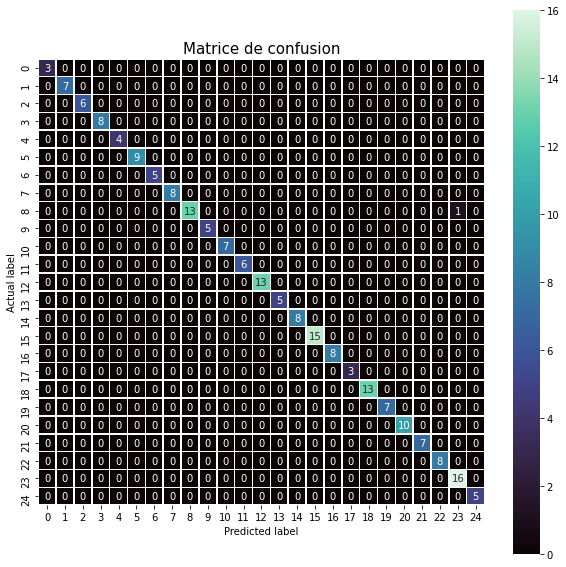

In [41]:
c_m_2 = confusion_matrix(y_test, result)
plt.figure(figsize=(10,10))
sns.heatmap(c_m_2, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'mako');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Matrice de confusion", size = 15)
plt.show()

In [42]:
score = accuracy_score(y_test,result)
print('Accuracy: {}'.format(score))

Accuracy: 0.995


## 6. Test depuis un CV pris en ligne en format PDF

In [43]:
from pdf2image import convert_from_path, convert_from_bytes
from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

In [46]:
carrie_hr = '3Carrie.pdf'

In [55]:
images = convert_from_path(carrie_hr, 500, poppler_path = r"C:\Users\utilisateur\Desktop\poppler-21.03.0\Library\bin")
#création d'images depuis le pdf
for i, image in enumerate(images):
    fname = 'image'+str(i)+'.png'
    image.save(fname, "PNG")

In [56]:
import pytesseract

pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files (x86)\Tesseract-OCR\tesseract.exe"

In [58]:
import cv2
#image avec texte
img_texte = cv2.imread('image0.png', 0) #noir et blanc
cv_test_2 = pytesseract.image_to_string(img_texte, lang='eng')
clean_test = clean( cv_test_2, remove_stopwords=True )
centroids_cv_test= create_bag_of_centroids( clean_test, word_centroid_map ) 
centroids_cv_test = centroids_cv_test.reshape(1, -1)
result_test = forest.predict(centroids_cv_test)
print(result_test)

['HR']
